In [151]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import cv2
from numpy.linalg import det, inv
import matplotlib.image as mpimg
from matplotlib.widgets import PolygonSelector
from PIL import Image

plt.style.use('default')

Task1

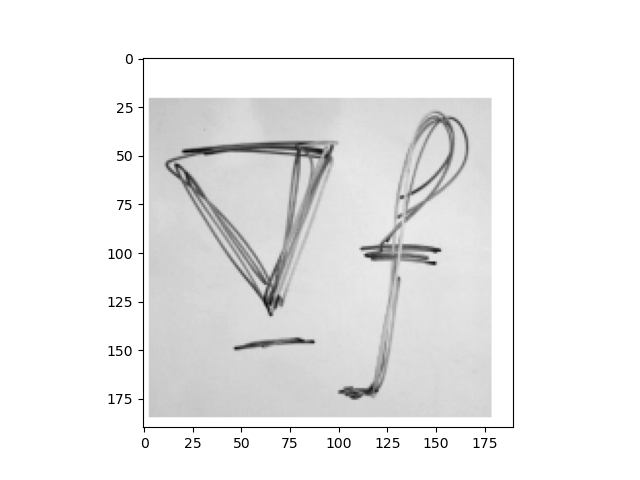

Polygon vertices:
[(30.13837753229842, 9.781383712570388), (26.025823419744313, 171.19913263031933), (179.218464112385, 141.89718457837125), (170.99335588727678, 24.175323106509794)]


In [152]:
# source_img_path = "InputImgs\\SrcImg.png"
# target_img_path = "InputImgs\\DstImg.png"
source_img_path = "InputImgs\\1.png"
target_img_path = "InputImgs\\2.png"
source_img_grey = cv2.imread(source_img_path, cv2.IMREAD_GRAYSCALE)
target_img_grey = cv2.imread(target_img_path, cv2.IMREAD_GRAYSCALE)
source_img = cv2.imread(source_img_path, cv2.IMREAD_COLOR)
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)
source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
target_img_ = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)


img_array = source_img_grey.copy()

# 回调函数，当选择完成时调用
def onselect(verts):
    global polygon
    polygon = [(y, x) for x, y in verts]
    print("Polygon vertices:")
    print(polygon)
    # 这里可以添加代码来处理多边形的顶点

# 创建图像和轴
fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')

# 创建PolygonSelector实例
polygon_selector = PolygonSelector(ax, onselect)

# 显示图像并开始多边形选择过程
plt.show()

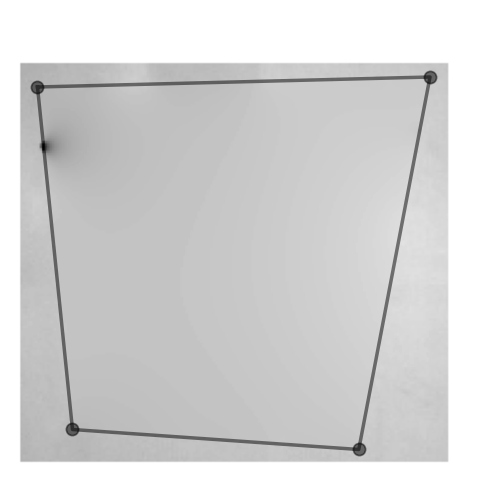

In [153]:
assert 0 != polygon.count, "Please select a polygon in the image above."

%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
from skimage.draw import polygon2mask
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix
from skimage.color import rgb2gray

gray_image = source_img_grey.copy()  # 转换为灰度图像

# 获取图像尺寸
image_height, image_width = gray_image.shape[:2]
# 创建多边形掩码
mask = polygon2mask((image_height, image_width), polygon)

# 获取多边形内部的像素索引
interior_idx = np.argwhere(mask)

# 初始化稀疏矩阵A和向量b
n_interior_pixels = len(interior_idx)
A = lil_matrix((n_interior_pixels, n_interior_pixels), dtype=float)
b = np.zeros(n_interior_pixels)

# 构建线性系统
for i, (row, col) in enumerate(interior_idx):
    A[i, i] = 4  # 主对角线元素
    for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 四个方向的邻居
        neighbor = (row + drow, col + dcol)
        if mask[neighbor]:  # 如果邻居在内部
            j = np.argwhere(np.all(interior_idx == neighbor, axis=1))[0, 0]
            A[i, j] = -1
        else:
            # 如果邻居在边界上或者在掩码外面，我们需要从源图像中获取对应的强度值
            b[i] += gray_image[neighbor]

# 将A矩阵转换为CSR格式
A_csr = A.tocsr()

# 求解线性系统
solution = spsolve(A_csr, b)

# 将解填充回图像的相应区域
for (solution_value, (row, col)) in zip(solution, interior_idx):
    # print(row, col)
    gray_image[row, col] = solution_value

# 显示填充后的图像
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

[170.32858617 169.01560244 171.56044342 ... 251.682136   251.28811664
 253.94840068]
[170.32838544 169.01501065 171.55985992 ... 251.6821553  251.28817328
 253.94839483]


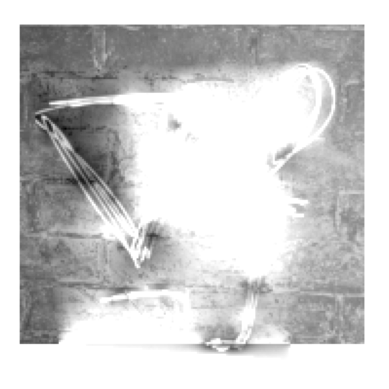

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [157]:
from scipy import signal, sparse
import numpy as np
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from scipy.sparse import linalg as linalg

# source_img_path = "InputImgs\\SrcImg.png"
# target_img_path = "InputImgs\\DstImg.png"
# source_img_path = "InputImgs\\1.png"
# target_img_path = "InputImgs\\2.png"
# source_img = Image.open(source_img_path).convert('L')
# target_img = Image.open(target_img_path).convert('L')
# source_img_array = np.array(source_img, dtype=np.uint8)
# target_img_array = np.array(target_img, dtype=np.uint8)

def compute_gradients(img):
    """Compute gradients of the image using forward differencing."""
    gx = np.roll(img, -1, axis=1) - img
    gy = np.roll(img, -1, axis=0) - img
    return gx, gy

def seamless_cloning(source_img, target_img, mask, polygon, mode='importing'):
    # 创建拉普拉斯算子
    laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    # 计算源图像的拉普拉斯算子
    grad_source = signal.convolve2d(source_img, laplacian, mode='same', boundary='fill', fillvalue=0)
    grad_target = signal.convolve2d(target_img, laplacian, mode='same', boundary='fill', fillvalue=0)
    # 获取掩码内的索引
    idx = np.argwhere(mask)
    
    # 创建系数矩阵A和向量b
    n_pixels = len(idx)
    A = lil_matrix((n_pixels, n_pixels))
    b = np.zeros(n_pixels)
    
    for i, (row, col) in enumerate(idx):
        A[i, i] = -4
        if mode == 'importing':
            b[i] = grad_source[row, col]
        elif mode == 'mixing':
            if abs(grad_source[row, col]) > abs(grad_target[row, col]):
                b[i] = grad_source[row, col]
            else:
                b[i] = grad_target[row, col]
        for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor = (row + drow, col + dcol)
            if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                if mask[neighbor]:
                    j = np.argwhere((idx == neighbor).all(axis=1))
                    if j.size > 0:
                        A[i, j[0][0]] = 1
                else:
                    b[i] -= target_img[neighbor]
    
    # 解线性方程组
    solution = spsolve(A.tocsr(), b)
    print(solution)
    solution, _ = linalg.cg(A.tocsr(), b)
    print(solution)
    #solution = np.round(solution).astype(np.uint8)

    # 创建一个新的目标图像以填充结果
    cloned_img = target_img.copy()
    for (row, col), value in zip(idx, solution):
        cloned_img[row, col] = np.clip(value, 0, 255)

    plt.imshow(cloned_img, cmap='gray')
    plt.axis('off')
    plt.show()
    return cloned_img

# 使用导入梯度
#seamless_cloning(source_img_grey, target_img_grey, mask, polygon, mode='importing')
seamless_cloning(source_img_grey, target_img_grey, mask, polygon, mode='mixing')

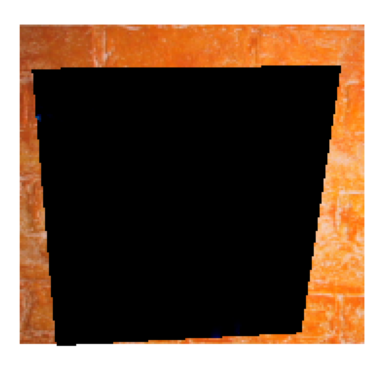

In [150]:
from PIL import Image
from scipy import signal, sparse
import numpy as np
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt

def compute_gradients(img):
    """Compute gradients of the image using forward differencing."""
    gx = np.roll(img, -1, axis=1) - img
    gy = np.roll(img, -1, axis=0) - img
    return gx, gy

def seamless_cloning(source_img, target_img, mask, mode='importing'):
    cloned_img = np.empty_like(target_img)
    for channel in range(3):
        source_channel = source_img[:,:,channel]
        target_channel = target_img[:,:,channel]

        # Compute Laplacian
        laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
        grad_source = signal.convolve2d(source_channel, laplacian, mode='same', boundary='fill', fillvalue=0)

        # Get mask indices
        idx = np.argwhere(mask)

        # Create coefficient matrix A and vector b
        n_pixels = len(idx)
        A = sparse.lil_matrix((n_pixels, n_pixels))
        b = np.zeros(n_pixels)

        for i, (row, col) in enumerate(idx):
            A[i, i] = 4
            for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor = (row + drow, col + dcol)
                if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                    if mask[neighbor]:
                        j = np.argwhere((idx == neighbor).all(axis=1))
                        if j.size > 0:
                            A[i, j[0][0]] = -1
                    else:
                        b[i] += target_channel[neighbor]

        # Choosing gradient
        if mode == 'importing':
            for i, (row, col) in enumerate(idx):
                b[i] += grad_source[row, col]
        elif mode == 'mixing':
            grad_target = signal.convolve2d(target_channel, laplacian, mode='same', boundary='fill', fillvalue=0)
            for i, (row, col) in enumerate(idx):
                if abs(grad_source[row, col]) > abs(grad_target[row, col]):
                    b[i] += grad_source[row, col]
                else:
                    b[i] += grad_target[row, col]

        # Solve linear system
        solution = spsolve(A.tocsr(), b)

        # Fill in the cloned image
        channel_cloned = target_channel.copy()
        for (row, col), value in zip(idx, solution):
            channel_cloned[row, col] = np.clip(value, 0, 255)
        cloned_img[:,:,channel] = channel_cloned

    return cloned_img


# 使用导入梯度
#result = seamless_cloning(source_img, target_img, mask.astype(bool), mode='importing')
result = seamless_cloning(source_img, target_img, mask.astype(bool), mode='mixing')

# 展示结果
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

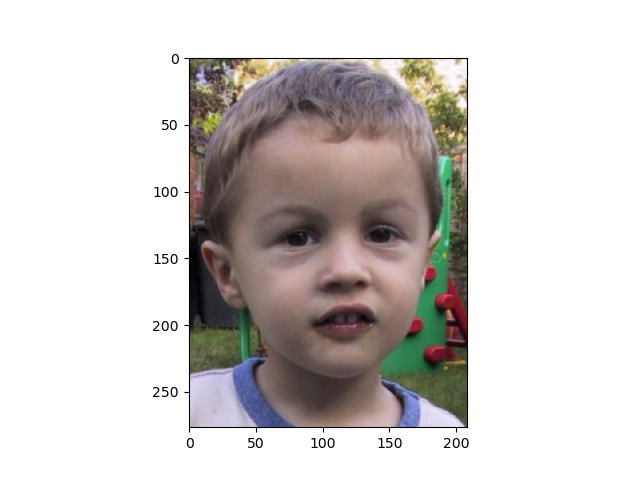

Polygon vertices:
[(103.37514637868642, 55.43506264789798), (101.1267697553098, 162.60768169551702), (127.35783036137039, 175.34848256131787), (218.0423541708942, 140.12391546175078), (214.29505979859982, 83.16504100287634), (133.35350135704138, 37.448049660884976)]


In [116]:
%matplotlib widget
# 应用纹理平坦化
img_path = "InputImgs//qwe.png"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_array = image.copy()

# 回调函数，当选择完成时调用
def onselect(verts):
    global polygon
    polygon = [(y, x) for x, y in verts]
    print("Polygon vertices:")
    print(polygon)
    # 这里可以添加代码来处理多边形的顶点

# 创建图像和轴
fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')

# 创建PolygonSelector实例
polygon_selector = PolygonSelector(ax, onselect)

# 显示图像并开始多边形选择过程
plt.show()

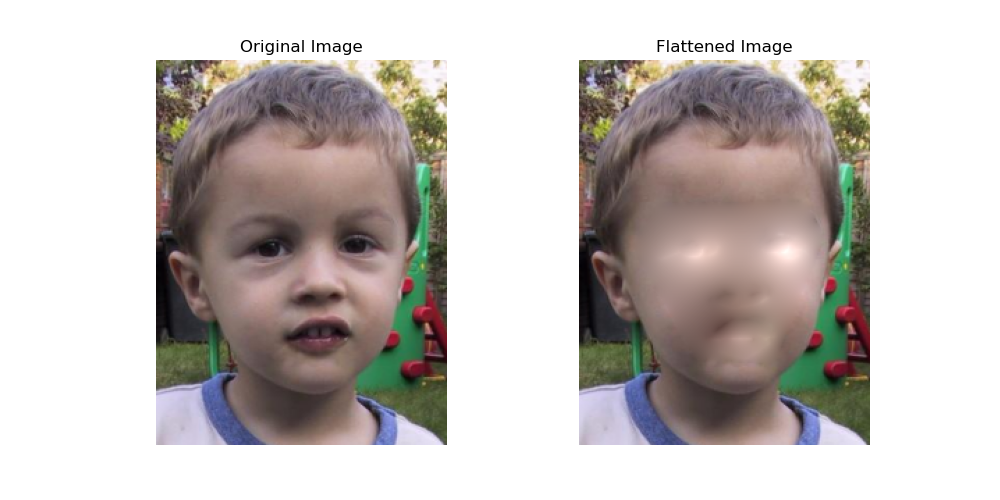

In [134]:
import numpy as np
import cv2
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def compute_laplacian(img):
    """计算图像的拉普拉斯算子，该算子用于表达图像特征"""
    laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    return signal.convolve2d(img, laplacian, mode='same', boundary='fill', fillvalue=0)

def texture_flattening(source_img, mask, strength=0.2):
    """纹理平坦化函数，通过修改图像梯度后使用泊松方程来平滑选定区域的纹理"""
    flattened_img = np.empty_like(source_img)
    mask = mask.astype(bool)  # 确保掩码是布尔类型

    for channel in range(3):  # 对于RGB的每个通道
        source_channel = source_img[:, :, channel]

        # 计算梯度和拉普拉斯
        gx, gy = compute_gradients(source_channel.astype(np.float64))
        gl = compute_laplacian(source_channel.astype(np.float64))

        # 计算边缘梯度
        edges = cv2.Canny(source_img, 60, 200)
        # # 使用matplotlib可视化结果
        # plt.figure(figsize=(8, 6))
        # plt.imshow(edges, cmap='gray')  # 边缘是白色，背景是黑色
        # plt.title('Canny Edge Detection')
        # plt.axis('off')  # 关闭坐标轴显示
        # plt.show()
        edges = edges.astype(bool)
        gx[~edges] = 0
        gy[~edges] = 0

        # 计算边缘拉普拉斯
        gl = gx + gy
        gl *= strength  # 通过强度因子调整纹理平坦化的效果

        # 建立方程组的A矩阵和b向量
        idx = np.argwhere(mask)
        n_pixels = len(idx)
        A = sparse.lil_matrix((n_pixels, n_pixels))
        b = np.zeros(n_pixels)

        for i, (row, col) in enumerate(idx):
            A[i, i] = 4
            for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor = (row + drow, col + dcol)
                if (0 <= neighbor[0] < mask.shape[0]) and (0 <= neighbor[1] < mask.shape[1]):
                    if mask[neighbor]:
                        j = np.argwhere((idx == neighbor).all(axis=1))
                        if j.size > 0:
                            A[i, j[0][0]] = -1
                    else:
                        b[i] += source_channel[neighbor]

        for i, (row, col) in enumerate(idx):
            b[i] += gl[row, col]  # Subtracts the gradient to remove the texture

        # 解决线性系统
        solution = spsolve(A.tocsr(), b)

        # 填充平坦化的图像
        channel_flattened = source_channel.copy()
        for (row, col), value in zip(idx, solution):
            channel_flattened[row, col] = np.clip(value, 0, 255)
        flattened_img[:, :, channel] = channel_flattened

    return flattened_img

# 应用纹理平坦化
img_path = "InputImgs//qwe.png"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_height, image_width = image.shape[:2]
mask = polygon2mask((image_height, image_width), polygon)
flat_img = texture_flattening(image, mask)

# 展示原始图像和平坦化后的图像
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(flat_img)
axes[1].set_title('Flattened Image')
axes[1].axis('off')

plt.show()
